In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ex1

trend = lambda x : 100 * (x - 0.5) ** 2
sezon = lambda x: np.sin(2 * np.pi * 5 * x) + np.sin(2 * np.pi * 7 * x)
variatii = lambda x:  np.random.normal(0,1,len(x))

N = 1000
time = np.linspace(0, 1, N)
t = trend(time)
s = sezon(time)
v = variatii(time)

signal = t + s + v 



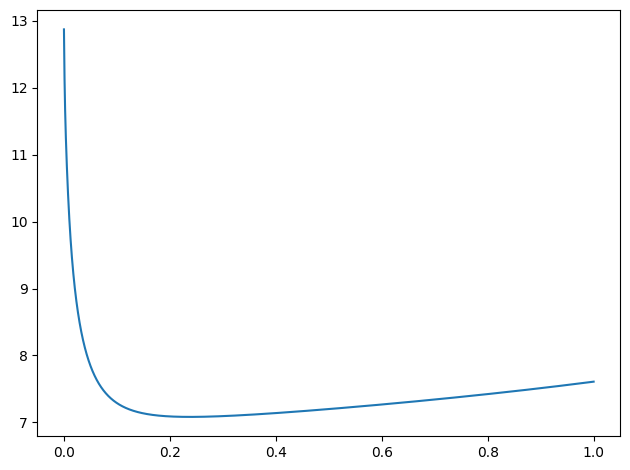

In [3]:
# ex2

def exponentialAverage(signal, alfa):
    s = [signal[0]]
    
    for x in signal[1:]:
        s.append(alfa * x + (1 - alfa) * s[-1])
        
    return s 

fig, axs = plt.subplots(2)
axs[0].plot(signal)
axs[1].plot(exponentialAverage(signal, 0.237))

fig.tight_layout()
fig.savefig("ex2_smoothed_signal.pdf")
fig.show()

def mse(x, s):
    return np.sum((x[1:] - s[:-1]) ** 2)

optimalAlfa = 0
minimumMse = np.inf
mseResults = []
alfas = np.linspace(0, 1, 10000)
for alfa in alfas:
    expSignal = exponentialAverage(signal, alfa)
    mseResults.append(mse(signal, expSignal))
    
    if mseResults[-1] < minimumMse:
        minimumMse = mseResults[-1]
        optimalAlfa = alfa
        
plt.clf()
plt.plot(alfas, np.log(mseResults))
plt.savefig("ex2_alfas.pdf")
plt.show()
    

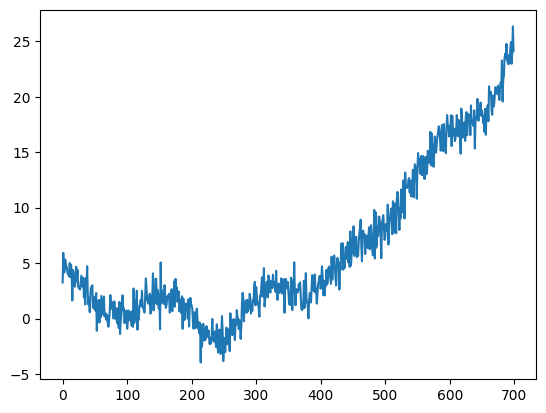

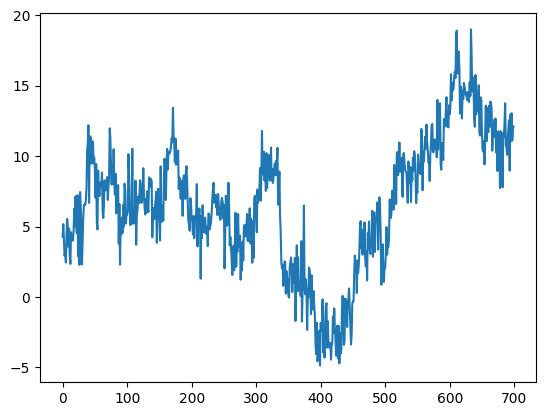

In [33]:
# ex3

p = 300
eps = np.random.normal(0, 1, len(signal))
A = eps[0: p]
for i in range(1, len(signal) - p):
    A = np.row_stack((A, eps[i : i + p]))
    
theta = np.linalg.lstsq(A, signal[p:], rcond=None)[0]

y_ma = A @ theta 
y_ma = y_ma + np.random.normal(0, 1, y_ma.size) + np.mean(signal[p:])

plt.plot(signal[p:])
plt.savefig("ex3_original_signal.pdf")
plt.show()
plt.plot(y_ma)
plt.savefig("ex3_reconstructed_signal.pdf")
plt.show()

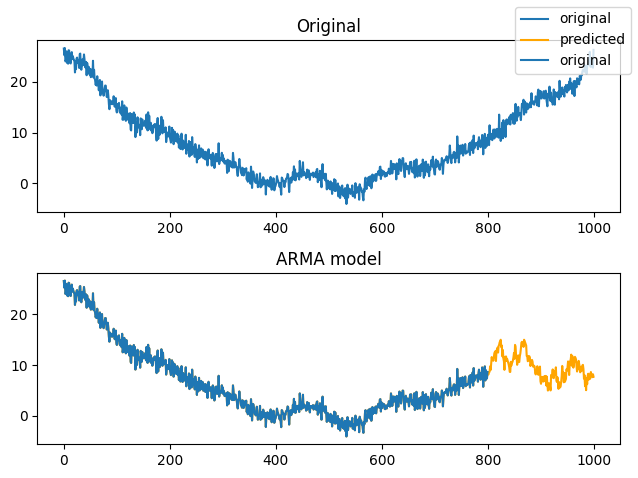

In [45]:
# ex4

def train(trainSignal, p, q):
    
    AR =  trainSignal[p - 1 : trainSignal.size - 1]
    for i in range(2, p + 1):
        shifted = trainSignal[p - i : trainSignal.size - i]
        AR = np.column_stack((AR, shifted))
    
    eps = np.random.normal(0, 1, len(trainSignal))
    MA = eps[0: q]
    for i in range(1, len(trainSignal) - q):
        MA = np.row_stack((MA, eps[i : i + q]))
        
    if p < q:
        AR = AR[q - p:]
    elif p > q:
        MA = MA[p - q:]
    A = np.concatenate((AR, MA), axis=1)
    params = np.linalg.lstsq(A, trainSignal[max(p, q):], rcond=None)[0]
    
    return params, eps
    
def predict(trainSignal, predictionsNeeded, p, q, params, eps):
    result = trainSignal.copy()
    for _ in range(predictionsNeeded):    
        newError = np.random.normal(0, 1, 1)
        y_pred = params.T @ (np.concatenate((result[-p : ], eps[-q : ]))) + newError
        result = np.append(result, y_pred)
        eps = np.append(eps, newError)
    
    return result

def mse(predictions, labels):
    mse = np.sum((predictions - labels) ** 2) / len(predictions)
    return mse
            
    
foldSize = 800
trainSignal = signal[: foldSize]
testSignal = signal[foldSize:]

bestMse = np.inf
bestParams = (2, 2)
for p in range(2, 21):
    for q in range(2, 21):
        params, eps = train(trainSignal, p, q)
        predictions = predict(trainSignal, len(testSignal), p, q, params, eps)
        mseValue = mse(predictions[foldSize: ], testSignal)
        
        if bestMse < mseValue:
            bestMse = mseValue
            bestParams = (p, q)
            

p, q = bestParams     
params, eps = train(signal, p, q)
predictions = predict(trainSignal, len(testSignal), p, q, params, eps)

fig, axs = plt.subplots(2)
axs[0].plot(signal, label="original")
axs[0].set_title("Original")
axs[1].plot(predictions, label="predicted", color="orange")
axs[1].plot(trainSignal, label="original")
axs[1].set_title("ARMA model")

fig.legend()
fig.tight_layout()
fig.savefig("ex4_my_arma.pdf")
fig.show()
        


/home/keyglock/Procesarea Semnalelor/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


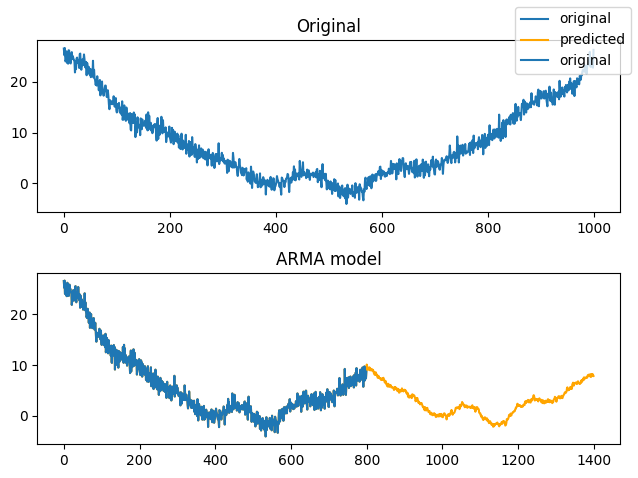

In [59]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(trainSignal, order=(2, 0, 2))
results = model.fit()
predictions = results.predict(len(testSignal))

fig, axs = plt.subplots(2)
axs[0].plot(signal, label="original")
axs[0].set_title("Original")
axs[1].plot(np.concatenate((trainSignal, predictions)), label="predicted", color="orange")
axs[1].plot(trainSignal, label="original")
axs[1].set_title("ARMA model")

fig.legend()
fig.tight_layout()
fig.savefig("ex4_library_arma.pdf")
fig.show()
        